Import Librerias

In [1]:
#Import 
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import Bounds
from sympy import Function, Symbol, evalf, Matrix, lambdify, Subs, Derivative, re
from sympy import sign, sqrt, Abs
import control as ct
#solver of NLP problem
import cyipopt
from cyipopt import minimize_ipopt


# Import math Library
import math
import time

ModuleNotFoundError: No module named 'cyipopt'

SubPrograms

In [6]:

def fob_NMPC(du,uk_1,ysp,Ts):
    #fob parametres
    #xv = du + np.zeros((Hp,1))                  # du: decision variables Hc*nu
    
    xmm = open_loop_sim(x0,du,uk_1,Hp,nu,ny,Ts,BCS_model) # dimension Hp*ny
    yssf = np.abs(BCS_output(xmm,Ts,uk_1))
    Q = q[0]*np.identity(Hp)                     # dimension Hp*ny x Hp*ny 
    Q2 = q[1]*np.identity(Hp)                    # dimension Hp*ny x Hp*ny 
    Qu = 0.4
    R = r*np.identity(nu)                        # dimension nu*nu
    yspH = np.asarray(ysp)*np.ones((Hp,nu))      # dimension Hp*ny
    utg = 90                                     # target na choke
    # Bias 
    eH = np.asarray(ypk) - np.asarray(ypk2)         # mismatch at time step k
    eeH = eH * np.ones((Hp,nu))  
    yH = yssf + eeH                                  # augmented vector of prediction plus bias
    
    for ku in range(Hc):
        uk_1 = uk_1 + du[ku]
    
    # Objective function of the controller
    #J = (yH[:,0]-yspH[:,0]).T @ Q @ (yH[:,0]-yspH[:,0])+ (yH[:,1]-yspH[:,1]).T @ Q2 @ (yH[:,1]-yspH[:,1])+   (uk_1[1] - utg).T*Qu*(uk_1[1] - utg)  +  du[0:nu].T @ R @ du[0:nu]                                                
    J = (yH[:,0]-yspH[:,0]).T @ Q @ (yH[:,0]-yspH[:,0])+ (yH[:,1]-yspH[:,1]).T @ Q2 @ (yH[:,1]-yspH[:,1]) + du[0:nu].T @ R @ du[0:nu]     
    return J

def open_loop_sim(x0m,du,uk_1,Hp,nu,ny,Ts,modelo):
    #ym = np.empty((Hp, 10))
    ym1 = []
    for k in range(Hp):
        uk_1 = uk_1 + du[0:nu] 
        ys   = odeint(modelo,x0m,Ts,args=(uk_1,)) # integrate jacketed_tank(t,h,modelo,uk_1),[0 Ts],x0m) ;
        # ANN, fuzzy, NARX, NARMAX, NOE etc.
        #ym = np.append(ym, ys[-1])            # dimension ny  
        ym1 += [[k, ys[-1]]]
        ym2 = np.array(ym1,dtype=object)     # list
        ym3 = ym2[0:len(ym2),1] # list array
        ym4 = np.vstack(ym3).astype(float)     # array
        #x0m = ym[k,:].T 
        #y = np.matrix('y;ym').T              # dimension Hp*ny
    return ym4

def BCS_plant(x,t,u):
    #X[0]=pbh , x[1]= pwh , x[2]= q ,x[3]=fq , x[4]= zc
    #U[0]= f, u[1] = Zc
    #u = (40,90)
    #Constantes
    g  = 9.81       # Gravitational acceleration constant [m/s²]
    Cc = 2e-5       # Choke valve constant
    A1 = 0.008107   # Cross-section area of pipe below ESP [m²]
    A2 = 0.008107   # Cross-section area of pipe above ESP [m²]
    D1 = 0.1016     # Pipe diameter below ESP [m]
    D2 = 0.1016     # Pipe diameter above ESP [m]
    hw = 1000       # Total vertical distance in well [m]
    L1 =  500       # Length from reservoir to ESP [m]
    L2 = 1200       # Length from ESP to choke [m]
    V1 = 4.054      # Pipe volume below ESP [m3]
    V2 = 9.729      # Pipe volume above ESP [m3]
    f0 = 60         # ESP characteristics reference freq [Hz]
    b1 = 1.5e9      # Bulk modulus below ESP [Pa]
    b2 = 1.5e9      # Bulk modulus above ESP [Pa]
    M  = 1.992e8    # Fluid inertia parameters [kg/m4]
    rho = 950       # Density of produced fluid [kg/mÃ?Â³]
    pr = 1.26e7     # Reservoir pressure
    PI = 2.32e-9    # Well productivy index [m3/s/Pa]
    mu  = 0.025     # Viscosity [Pa*s]
    dfq_max = 0.5   # máxima variação em f/s
    dzc_max = 1     # máxima variação em zc %/s
    tp = np.array([[1.0/dfq_max],[1.0/dzc_max]]) # Actuator Response time 
    CH = -0.03*mu + 1
    Cq = 2.7944*mu**4 - 6.8104*mu**3 + 6.0032*mu**2 - 2.6266*mu + 1
    pm = 2e6  
       
    # Calculo do HEAD e delta de pressão
    q0 = x[2]/Cq*(f0/x[3])
    H0 = -1.2454e6*q0**2 + 7.4959e3*q0 + 9.5970e2
    H = CH*H0*(x[3]/f0)**2 # Head 
    Pp = rho*g*H      # Delta de pressão
    # Calculo da pressão de intaike
    F1 = 0.158*((rho*L1*(x[2])**2)/(D1*(A1)**2))*(mu/(rho*D1*np.absolute(x[2])))**(1/4)
    F2 = 0.158*((rho*L2*(x[2])**2)/(D2*(A2)**2))*(mu/(rho*D2*np.absolute(x[2])))**(1/4)
   
    
    # Vazao do rezervatorio vazao da chocke
    qr  = PI*(pr - x[0])
    qc  = Cc*(x[4]/100)*np.sign((x[1] - pm))*np.sqrt(np.absolute(x[1] - pm))
           
    #EDO
    dpbhdt = b1/V1*(qr - x[2])                         #x1
    dpwhdt = b2/V2*(x[2] - qc)                          #x2
    dqdt = 1/M*(x[0] - x[1] - rho*g*hw - F1 - F2 + Pp) #x3
    dfqdt = (u[0] - x[3])/tp[0,0]                     #x4
    dzcdt = (u[1] - x[4])/tp[1,0]                      #x5
    
    # Impondo a máxima variação das entradas
    # = (fqref - fq)/tp[0,0];
    #dzcdt = (zcref - zc)/tp[0,0]);
    #dudt = np.zeros((2, 1))
    
   # if (np.absolute(dfqdt)>dfq_max):
    #    dudt[0] = np.sign(dfqdt)*dfq_max
    #else:
    #    dudt[0] = dfqdt

   
    #if (np.absolute(dzcdt)>dzc_max):
     #   dudt[1] = np.sign(dzcdt)*dzc_max
    #else:
     #   dudt[1] = dzcdt
 
    #out
    #y = [Pin,H,P,I]
    dxdt = [dpbhdt,dpwhdt,dqdt,dfqdt,dzcdt]
    
    return dxdt

def BCS_model(x,t,u):
    #X[0]=pbh , x[1]= pwh , x[2]= q ,x[3]=fq , x[4]= zc
    #U[0]= f, u[1] = Zc
    #u = (40,90)
    #Constantes
    g  = 9.81       # Gravitational acceleration constant [m/s²]
    Cc = 2e-5       # Choke valve constant
    A1 = 0.008107   # Cross-section area of pipe below ESP [m²]
    A2 = 0.008107   # Cross-section area of pipe above ESP [m²]
    D1 = 0.1016     # Pipe diameter below ESP [m]
    D2 = 0.1016     # Pipe diameter above ESP [m]
    hw = 1000       # Total vertical distance in well [m]
    L1 =  500       # Length from reservoir to ESP [m]
    L2 = 1200       # Length from ESP to choke [m]
    V1 = 4.054      # Pipe volume below ESP [m3]
    V2 = 9.729      # Pipe volume above ESP [m3]
    f0 = 60         # ESP characteristics reference freq [Hz]
    b1 = 1.5e9      # Bulk modulus below ESP [Pa]
    b2 = 1.5e9      # Bulk modulus above ESP [Pa]
    M  = 1.992e8    # Fluid inertia parameters [kg/m4]
    rho = 950       # Density of produced fluid [kg/mÃ?Â³]
    pr = 1.26e7     # Reservoir pressure
    PI = 2.32e-9    # Well productivy index [m3/s/Pa]
    mu  = 0.025     # Viscosity [Pa*s]
    dfq_max = 0.5   # máxima variação em f/s
    dzc_max = 1     # máxima variação em zc %/s
    tp = np.array([[1.0/dfq_max],[1.0/dzc_max]]) # Actuator Response time 
    CH = -0.03*mu + 1
    Cq = 2.7944*mu**4 - 6.8104*mu**3 + 6.0032*mu**2 - 2.6266*mu + 1
    pm = 2e6  
       
    # Calculo do HEAD e delta de pressão
    q0 = x[2]/Cq*(f0/x[3])
    H0 = -1.2454e6*q0**2 + 7.4959e3*q0 + 9.5970e2
    H = CH*H0*(x[3]/f0)**2 # Head 
    Pp = rho*g*H      # Delta de pressão
    # Calculo da pressão de intaike
    F1 = 0.158*((rho*L1*x[2]**2)/(D1*A1**2))*(mu/(rho*D1*np.abs(x[2])))**(1/4)
    F2 = 0.158*((rho*L2*x[2]**2)/(D2*A2**2))*(mu/(rho*D2*np.abs(x[2])))**(1/4)
    # Vazao do rezervatorio vazao da chocke
    qr  = PI*(pr - x[0])
    qc  = Cc*(x[4]/100)*np.sign((x[1] - pm))*np.sqrt(np.absolute(x[1] - pm))
           
    #EDO
    dpbhdt = b1/V1*(qr - x[2])                         #x1
    dpwhdt = b2/V2*(x[2] - qc)                          #x2
    dqdt = 1/M*(x[0] - x[1] - rho*g*hw - F1 - F2 + Pp) #x3
    dfqdt = (u[0] - x[3])/tp[0,0]                     #x4
    dzcdt = (u[1] - x[4])/tp[1,0]                      #x5
    # Impondo a máxima variação das entradas
    # = (fqref - fq)/tp[0,0];
    #dzcdt = (zcref - zc)/tp[0,0]);
    #dudt = np.zeros((2, 1))
    #
    #if (np.absolute(dfqdt)>dfq_max):
    #    dudt[0] = np.sign(dfqdt)*dfq_max
    #else:
    #    dudt[0] = dfqdt
    #if (np.absolute(dzcdt)>dzc_max):
    #    dudt[1] = np.sign(dzcdt)*dzc_max
    #else:
    #    dudt[1] = dzcdt
 
    #out
    #y = [Pin,H,P,I]
    dxdt = [dpbhdt,dpwhdt,dqdt,dfqdt,dzcdt]
    
    return dxdt

def find_intersection(points1, points2):
    x1, y1 = points1
    x2, y2 = points2

    # Ajuste de mínimos cuadrados para encontrar la ecuación de la recta que mejor se ajusta a los puntos
    line1_coeffs = np.polyfit(x1, y1, 1)  # Ajuste polinómico de grado 1 (ecuación de la recta)
    line2_coeffs = np.polyfit(x2, y2, 1)  # Ajuste polinómico de grado 1 (ecuación de la recta)

    A1, B1 = line1_coeffs[0], -1
    A2, B2 = line2_coeffs[0], -1

    determinant = A1 * B2 - A2 * B1

    if determinant == 0:
        return None  # Las rectas son paralelas o coincidentes, no hay intersección única

    C1 = line1_coeffs[1]
    C2 = line2_coeffs[1]

    x = (C1 * B2 - C2 * B1) / determinant
    y = (A1 * C2 - A2 * C1) / determinant

    return -1*x, -1*y


def Bcs_Hlim(qk):
    p_max = 100
    f0    = 60    
    mu    = 0.025     #  Viscosity [Pa*s]
    q0_dt = 25/3600 #   Downtrhust flow at f0
    q0_ut = 50/3600 #   Uptrhust flow at f0
    CH    = -0.03*mu + 1
    Cq    = 2.7944*mu**4 - 6.8104*mu**3 + 6.0032*mu**2 - 2.6266*mu + 1
    Cp    = -4.4376*mu**4 + 11.091*mu**3 -9.9306*mu**2 + 3.9042*mu + 1
    
    # Região de operação Downtrhust e Upthrust
    H0_dt = -1.2454e6*q0_dt**2 + 7.4959e3*q0_dt + 9.5970e2
    H0_dt = CH*H0_dt*(f0/f0)**2
    H0_ut = -1.2454e6*q0_ut**2 + 7.4959e3*q0_ut + 9.5970e2
    H0_ut = CH*H0_ut*(f0/f0)**2
    # Variacao frequencia
    f     = np.linspace(30,70,p_max)   #  Hz
    H_ut  = H0_ut*(f/f0)**2
    H_dt  = H0_dt*(f/f0)**2
    # corrige lei da afinidade
    Qdt   = q0_dt*f/f0
    Qut   = q0_ut*f/f0
    # Variacao vazao
    flim  = np.linspace(35,65,5)
    qop   = np.linspace(0,q0_ut*flim[-1]/f0,100)   #m3/s
    #Hop = np.zeros((len(flim),len(qop)))
    Hop   = []
    for i in range(len(flim)):
        q0  = qop/Cq*(f0/flim[i])
        H0  = -1.2454e6*q0**2 + 7.4959e3*q0 + 9.5970e2
        Hop += [[i, CH*H0*(flim[i]/f0)**2]]
    
    # Calculo dos pontos de interseção para delimitação da região
    ip1,ip2 = find_intersection((qop*3600,Hop[0][1]),(Qdt*3600,H_dt))
    ip3,ip4 = find_intersection((Qdt*3600,H_dt),(qop*3600,Hop[4][1]))
    ip5,ip6 = find_intersection((qop*3600,Hop[4][1]),(Qut*3600,H_ut))
    ip7,ip8 = find_intersection((Qut*3600,H_ut),(qop*3600,Hop[0][1]))
    
    # Ajuste do polinomio de frequencia maxima 65 Hz
    p_35hz = np.polyfit(qop*3600,Hop[0][1],p_max)
    q_35hz = np.linspace(ip1,ip7,p_max)
    H_35hz =  np.polyval(p_35hz, q_35hz)
    
    # Ajuste do polinomio de frequencia minima 35 Hz
    p_65hz = np.polyfit(qop*3600,Hop[4][1],p_max)
    #H_65hz = lambda qk: np.mean(p_65hz * qk)
    #H_65hz =  p_65hz*11.45
    q_65hz = np.linspace(ip3,ip5,p_max)
    H_65hz = np.polyval(p_65hz,q_65hz)
    
    #Ajuste do polinomio de Downtrhust
    p_dt = np.polyfit(Qdt*3600,H_dt,p_max)
    #H_dt = lambda qk: np.mean(p_dt * qk)
    q_dt = np.linspace(ip1,ip3,p_max)
    H_dt = np.polyval(p_dt,q_dt)
    
    # Ajuste do polinomio de Uptrhust
    p_ut = np.polyfit(Qut*3600,H_ut,p_max)
    #H_ut = lambda qk:  np.mean(p_ut * qk)
    q_ut = np.linspace(ip7,ip5,p_max)
    H_ut = np.polyval(p_ut,q_ut)
    
    
    if qk*3600 < ip1:
        h_lim = [ip1, ip2]
    elif qk*3600 < ip2:
        #h_lim = [H_35hz(qk*3600),H_dt(qk*3600)]
        h_lim = [*H_35hz, *H_dt]
    elif qk*3600 < ip4:
        #h_lim = [H_35hz(qk*3600),H_65hz(qk*3600)]
        h_lim = [*H_35hz, *H_65hz ]
    elif qk*3600 < ip3:
        #h_lim = [H_ut(qk*3600),H_65hz(qk*3600)]
        h_lim = [*H_ut, *H_65hz]
    else:
        h_lim = [ip5, ip5]
    
    return p_35hz,H_35hz,q_35hz,p_65hz,H_65hz,q_65hz,p_dt,H_dt,q_dt,p_ut,H_ut,q_ut,h_lim


def hlim(qk):   
    if qk*3600 < ip1:
        h_lim = [ip1, ip2]
    elif qk*3600 < ip2:
        #h_lim = [H_35hz(qk*3600),H_dt(qk*3600)]
        h_lim = [*H_35hz, *H_dt]
    elif qk*3600 < ip4:
        #h_lim = [H_35hz(qk*3600),H_65hz(qk*3600)]
        h_lim = [*H_35hz, *H_65hz ]
    elif qk*3600 < ip3:
        #h_lim = [H_ut(qk*3600),H_65hz(qk*3600)]
        h_lim = [*H_ut, *H_65hz]
    else:
        h_lim = [ip5, ip5]
    return h_lim

def BCS_output_ekf(x,t,u):

    g  = 9.81       # Gravitational acceleration constant [m/s²]
    A1 = 0.008107   # Cross-section area of pipe below ESP [m²]
    D1 = 0.1016     # Pipe diameter below ESP [m]
    h1 = 200        # Heigth from reservoir to ESP [m]
    L1 =  500       # Length from reservoir to ESP [m]
    f0 = 60         # ESP characteristics reference freq [Hz]
    Inp = 65        # ESP motor nominal current [A]
    Pnp = 1.625e5   # ESP motor nominal Power [W]
    rho = 950       # Density of produced fluid [kg/mÃ?Â³]
    mu  = 0.025     # Viscosity [Pa*s]
    CH = -0.03*mu + 1
    Cq = 2.7944*mu**4 - 6.8104*mu**3 + 6.0032*mu**2 - 2.6266*mu + 1
    Cp = -4.4376*mu**4 + 11.091*mu**3 -9.9306*mu**2 + 3.9042*mu + 1
    # Calculo do HEAD e delta de pressão
    q0 = x[2]/Cq*(f0/x[3])
    P0 = -2.3599e9*q0**3 -1.8082e7*q0**2 +4.3346e6*q0 + 9.4355e4
    H0 = -1.2454e6*q0**2 + 7.4959e3*q0 + 9.5970e2
    # Calculo da pressão de intaike
    F1 = 0.158*((rho*L1*x[2]**2)/(D1*A1**2))*(mu/(rho*D1*np.abs(x[2])))**(1/4)

    Pin =  x[0] - rho*g*h1 - F1 # Pressao Intake
    P = Cp*P0*(x[3]/f0)**3    # Potencia
    I = Inp*(Cp*P0*(x[3]/f0)**3)/Pnp                 # Corrente
    H = CH*H0*((x[3])/f0)**2   # Head
    ym = [Pin,H,P,I,q0]
    return ym


def linearizacao_bcs(X,U,t):
    #X[0]=pbh , x[1]= pwh , x[2]= q ,x[3]=fq , x[4]= zc
    #U[0]= f, u[1] = Zc
    #u = (40,90)
    #Constantes
    g  = 9.81       # Gravitational acceleration constant [m/s²]
    Cc = 2e-5       # Choke valve constant
    A1 = 0.008107   # Cross-section area of pipe below ESP [m²]
    A2 = 0.008107   # Cross-section area of pipe above ESP [m²]
    D1 = 0.1016     # Pipe diameter below ESP [m]
    D2 = 0.1016     # Pipe diameter above ESP [m]
    h1 = 200        # Heigth from reservoir to ESP [m]
    hw = 1000       # Total vertical distance in well [m]
    L1 =  500       # Length from reservoir to ESP [m]
    L2 = 1200       # Length from ESP to choke [m]
    V1 = 4.054      # Pipe volume below ESP [m3]
    V2 = 9.729      # Pipe volume above ESP [m3]
    f0 = 60         # ESP characteristics reference freq [Hz]
    Inp = 65        # ESP motor nominal current [A]
    Pnp = 1.625e5   # ESP motor nominal Power [W]
    b1 = 1.5e9      # Bulk modulus below ESP [Pa]
    b2 = 1.5e9      # Bulk modulus above ESP [Pa]
    M  = 1.992e8    # Fluid inertia parameters [kg/m4]
    rho = 950       # Density of produced fluid [kg/mÃ?Â³]
    pr = 1.26e7     # Reservoir pressure
    PI = 2.32e-9    # Well productivy index [m3/s/Pa]
    mu  = 0.025     # Viscosity [Pa*s]
    dfq_max = 0.5   # máxima variação em f/s
    dzc_max = 1     # máxima variação em zc %/s
    tp = np.array([[1.0/dfq_max],[1.0/dzc_max]]) # Actuator Response time 
    CH = -0.03*mu + 1
    Cq = 2.7944*mu**4 - 6.8104*mu**3 + 6.0032*mu**2 - 2.6266*mu + 1
    Cp = -4.4376*mu**4 + 11.091*mu**3 -9.9306*mu**2 + 3.9042*mu + 1
    pm = 2e6  
      
    # Calculo do HEAD e delta de pressão
    q0 = X[2]/Cq*(f0/X[3])
    H0 = -1.2454e6*q0**2 + 7.4959e3*q0 + 9.5970e2
    H = CH*H0*(X[3]/f0)**2 # Head 
    Pp = rho*g*H      # Delta de pressão
    # Calculo da Potencia e corrente da bomba
    P0 = -2.3599e9*q0**3 -1.8082e7*q0**2 +4.3346e6*q0 + 9.4355e4
    # Calculo da pressão de intaike
    F1 = 0.158*((rho*L1*X[2]**2)/(D1*A1**2))*(mu/(rho*D1*X[2]))**(1/4)
    F2 = 0.158*((rho*L2*X[2]**2)/(D2*A2**2))*(mu/(rho*D2*X[2]))**(1/4)
   
    
    # Vazao do rezervatorio vazao da chocke
    qr  = PI*(pr - X[0])
    qc  = Cc*(X[4]/100)*sign((X[1] - pm))*sqrt(Abs(X[1] - pm))
           
    #EDO
    dpbhdt = b1/V1*(qr - X[2])                         #x1
    dpwhdt = b2/V2*(X[2] - qc)                          #x2
    dqdt = 1/M*(X[0] - X[1] - rho*g*hw - F1 - F2 + Pp) #x3
    dfqdt = (U[0] - X[3])/tp[0,0]                     #x4
    dzcdt = (U[1] - X[4])/tp[1,0]                      #x5
       
    # out
    
    dxdt = Matrix([dpbhdt,dpwhdt,dqdt,dfqdt,dzcdt])
    #-------------------------------------------------
    # Calculo do HEAD e delta de pressão
    #-------------------------------------------------
    
    P0 = -2.3599e9*q0**3 -1.8082e7*q0**2 +4.3346e6*q0 + 9.4355e4
    H0 = -1.2454e6*q0**2 + 7.4959e3*q0 + 9.5970e2
    # Calculo da pressão de intaike
    
    Pin = X[0] - rho*g*h1 - F1         # Pressao Intake
    P = Cp*P0*(X[3]/f0)**3             # Potencia
    I = Inp*(Cp*P0*(X[3]/f0)**3)/Pnp   # Corrente
    
    
    y = Matrix([Pin,H,P,I])                   # Variaveis de saída
    
    # Jacobian
    X1 = Matrix(X)
    U1 = Matrix(U)
    Ak = dxdt.jacobian(X1)
    Bk = dxdt.jacobian(U1)
    Ck = y.jacobian(X1)
    Dk = y.jacobian(U1)   
    
    return [Ak,Bk,Ck,Dk]    


def lin_bcsx0(Ak,Bk,Ck,Dk,xmk,UU):
    x01 = xmk[0]
    x02 = xmk[1]
    x03 = xmk[2]
    x04 = xmk[3]
    x05 = xmk[4]
    #uk01 = UU[0]
    #uk02 = UU[1]
    #uk3 = u(3)
    A = (Ak).evalf().subs({X[0]: x01, X[1]: x02, X[2]:x03, X[3]:x04, X[4]:x05 })
    Anp = np.array(A)
    Anp[1][1]=0
    B = (Bk).evalf().subs({X[0]: x01, X[1]: x02, X[2]:x03, X[3]:x04, X[4]:x05 })
    Bnp = np.array(B)
    C = (Ck).evalf().subs({X[0]: x01, X[1]: x02, X[2]:x03, X[3]:x04, X[4]:x05 })
    Cnp = np.array(C)
    
    return Anp,Bnp,Cnp

def ekf_bruno(X,ukk,tt,Ak,Bk,Ck,Dk,xmk,ypk,W,V,Mk,modelo):
    
    # EKF - Predicao
    
    xpk = odeint(modelo,xmk,tt,args=(ukk,)) # integrate
    xmkn = xpk[0]
    ymk = BCS_output_ekf(xmkn,tt,ukk)

    # Linearizacao 

    x01 = xmk[0]
    x02 = xmk[1]
    x03 = xmk[2]
    x04 = xmk[3]
    x05 = xmk[4]
    #uk01 = UU[0]
    #uk02 = UU[1]
    #uk3 = u(3)
    A = (Ak).evalf().subs({X[0]: x01, X[1]: x02, X[2]:x03, X[3]:x04, X[4]:x05 })
    Anp = np.array(A)
    Anp[1][1]=0
    B = (Bk).evalf().subs({X[0]: x01, X[1]: x02, X[2]:x03, X[3]:x04, X[4]:x05 })
    Bnp = np.array(B)
    C = (Ck).evalf().subs({X[0]: x01, X[1]: x02, X[2]:x03, X[3]:x04, X[4]:x05 })
    Cnp = np.array(C)
    
    #C = C[[1,2],:]   # separando a matiz C só para as pv (pin,H)
    #  Discretização
    Ts = 2
    D = np.matrix(np.zeros([4,2]))
    sys = ct.ss(Anp,Bnp,Cnp,D)
    sys_d = ct.c2d(sys,Ts,'zoh');
    (Asd,Bsd,Csd,Dsd )= ct.ssdata(sys_d)
    
    #Csd_del = np.delete(Csd, 0, axis=1)
    #Csd_del = np.delete(Csd_del, 0, axis=1)
    #Csd_del = np.delete(Csd_del, 2, axis=1)
    
    Phi = Asd
    
    # Calculo da matriz de covariancia Mk
    Mk1 = Phi @ Mk @ Phi.T + W
    Csd1 = np.r_[ Csd, [np.zeros(5)] ]
    # EKF - correcao dos estados estimados
    Kf = np.linalg.lstsq(Mk1@ Csd1.T, Csd1@ Mk@ Csd1.T + V)    # calculdo ganho
    Mk2 = (np.eye(len(xmk)) - Kf[0] @ Csd1) @ Mk1              # atualizacao da matriz de variancia dos estados estimados
    xmk1 = np.abs(xmk + (Kf[0][0:2]).T@(ypk - ymk[0:2]))       # correcao dos estados
    
    return xmk1,Mk2

def BCS_output(x,t,u):

        
    # Vec State 
    pbh_x0 = [] 
    pwh_x1 = []
    q_x2   = []
    fq_x3  = []
    zc_x4  = []
    Pin = []
    H = []
    P = []
    I = []
    ym1 = []
    for i in range(len(x)):
        # Split state of bcs
        pbh_x0.append(x[i][0])
        pwh_x1.append(x[i][1])
        q_x2.append(x[i][2])
        fq_x3.append(x[i][3])
        zc_x4.append(x[i][4])
        #Constantes
        g  = 9.81       # Gravitational acceleration constant [m/s²]
        A1 = 0.008107   # Cross-section area of pipe below ESP [m²]
        D1 = 0.1016     # Pipe diameter below ESP [m]
        h1 = 200        # Heigth from reservoir to ESP [m]
        L1 =  500       # Length from reservoir to ESP [m]
        f0 = 60         # ESP characteristics reference freq [Hz]
        Inp = 65        # ESP motor nominal current [A]
        Pnp = 1.625e5   # ESP motor nominal Power [W]
        rho = 950       # Density of produced fluid [kg/mÃ?Â³]
        mu  = 0.025     # Viscosity [Pa*s]
        CH = -0.03*mu + 1
        Cq = 2.7944*mu**4 - 6.8104*mu**3 + 6.0032*mu**2 - 2.6266*mu + 1
        Cp = -4.4376*mu**4 + 11.091*mu**3 -9.9306*mu**2 + 3.9042*mu + 1
        # Calculo do HEAD e delta de pressão
        q0 = x[i][2]/Cq*(f0/x[i][3])
        P0 = -2.3599e9*q0**3 -1.8082e7*q0**2 +4.3346e6*q0 + 9.4355e4
        H0 = -1.2454e6*q0**2 + 7.4959e3*q0 + 9.5970e2
        # Calculo da pressão de intaike
        F1 = 0.158*((rho*L1*x[i][2]**2)/(D1*A1**2))*(mu/(rho*D1*np.abs(x[i][2])))**(1/4)

        Pin += [ x[i][0] - rho*g*h1 - F1 ]# Pressao Intake
        P += [Cp*P0*(x[i][3]/f0)**3]    # Potencia
        I += [Inp*(Cp*P0*(x[i][3]/f0)**3)/Pnp]                 # Corrente
        H += [CH*H0*((x[i][3])/f0)**2]   # Head
        ym1 += [[i, x[i][0] - rho*g*h1 - F1, CH*H0*((x[i][3])/f0)**2]]
        ym2 = np.array(ym1)                    # list
        ym3 = ym2[0:len(ym2),1:5]              # list array
    return ym3




Inicial Values

In [16]:
nsim = 150                     # number of simulation
uk_1 = np.array([50,50])       # manipulated variable
# steady-state conditions
xss = np.array([8311024.82175957, 2990109.06207437, 0.00995042241351780, 50, 50])
uss = np.array([50, 50])
yss = np.array([6000142.88550200, 592.126490003812])
x0 = np.array([8311024.82175957,2990109.06207437,0.00995042241351780,50,50]) # state variables
x0m = np.array([8311024.82175957,2990109.06207437,0.00995042241351780,50,50])
ypk = yss
ypk2 = yss
xmk = x0
ymk = yss          # condição inicial para o EKF
xmk[3] = 0.0106    #  inicia a vazao de um x0 diferente para testar converg.
xmk2 = x0 
ymk2 = yss         # estados da simulação do modelo nominal
utg = 90           # target na choke
pm = 2e6           # pressão da manifold

#--------------------------------------------------------------------------
# Linearizaçao para o EKF
#--------------------------------------------------------------------------

TT = np.linspace(0,nsim)
X0 = Symbol('x0')
X1 = Symbol('x1')
X2 = Symbol('x2')
X3 = Symbol('x3')
X4 = Symbol('x4')
U0 = Symbol('u0')
U1 = Symbol('u1')
X = [X0,X1,X2,X3,X4]
U = [U0,U1]
[Ak,Bk,Ck,Dk] = linearizacao_bcs(X,U,TT) # Calculo das Jacobianas
A,B,C = lin_bcsx0(Ak,Bk,Ck,Dk,xss,uk_1)
# Variancia da medição (R)
V = ((0.01/3)*np.diag(x0))**2
# Variancia do modelo (Q)
W = ((0.01/3)*np.diag(x0))**2
# Variancia da estimacao
Mk = W
Vruido = ((0.01/3)*np.diag(yss))**2


#--------------------------------------------------------------------------
# Controller parameters
#--------------------------------------------------------------------------

Hp   = 10          # prediction horizon
Hc   = 2           # control horizon
q    =  np.array([1e6,1e8]) /((yss.T)**2)    # weights on controlled variables 
r    = np.array([10,1]) /(uss.T**2)          # weights on control actions
qu   = 1000 /(uss[1]**2)                     # weights on controlled variables 
r    = 0.1         # weights on control actions
Ts   = 2           # sampling time [=] min
ny   = 2
nu   = 2

#--------------------------------------------------------------------------
# Noise
#--------------------------------------------------------------------------

np.random.seed(42)
mean = 0
std = 1 
num_samples = nsim
noise = np.random.normal(mean, std, size=num_samples)

#--------------------------------------------------------------------------
# constraints on inputs
#--------------------------------------------------------------------------
umin  = np.array([35,0])        #  lower bounds of inputs
umax  = np.array([65,100])      #  upper bounds of inputs 
dumax = Ts * np.array([0.5,0.5])  #  maximum variation of input moves: [0.5 Hz/s; 0.5 %/s]

# Auxiliary matrices for using in the solver
Dumax = np.vstack((dumax,dumax))                
Dumin = -Dumax
auxM = np.vstack((np.eye(nu),np.zeros((nu,nu)))).T
auxM1 = np.vstack((np.eye(nu),np.eye(nu))).T
Mtil = np.vstack((auxM,auxM1))
Itil = np.vstack((np.eye(nu),np.eye(nu)))
Ain = np.vstack((Mtil,-Mtil))

Bin = lambda ukk_1: [np.tile(umax.reshape(2,1),(Hc,1)) - Itil@ukk_1, Itil@ukk_1 - np.tile(umin.reshape(2,1),(Hc,1))]

ineq_cons = {'type': 'ineq', 'fun' : lambda x: np.array([BBin[0][0][0] - x[0],
                                                         BBin[0][1][0] - x[1],
                                                    BBin[0][1][0] - x[0]-x[2],
                                                    BBin[0][1][1] - x[1]-x[3],
                                                         BBin[1][0][0] + x[0],
                                                         BBin[1][1][0] + x[1],
                                                    BBin[1][1][0] + x[0]+x[2],
                                                     BBin[1][1][1]+ x[1]+x[3]])}


bnds =[(-1, 1), (-1, 1), (35, 65), (0, 100)]
#--------------------------------------------------------------------------
# Initial condition
#--------------------------------------------------------------------------
du0 = np.array([0.0, 0.0, 50.0, 50.0])  #Initial guess for decision variables (\Delta u_k)
tcalc = []
uk    = []
J_k   = []
yp    = []
ym    = []
em_h  = []
sp    = []
Ym_h  = []
Xmk_h = []
yp2_h = []
yp2   = []
xm_h  = []
xs_h  = []
res_suc_h    = []
res_status_h = []
res_nfev_h   = []
res_njev_h   = []

Simulation

In [ ]:

for k in range(nsim):
    #   k
    #   changes on set-points
    if k <= 50:
        ysp = np.array([8800000,320])
    else:
        ysp =  np.array([6000000,692])
    
    #control law 
    t = time.time()
    Ts = np.linspace(0,k,30)
    BBin = Bin(uk_1)
    fob = lambda du: fob_NMPC(du,uk_1,ysp,Ts)
    res = minimize_ipopt(fob, du0.reshape(4,1), bounds=bnds, constraints = ineq_cons, options={'disp': 10,'max_iter': 50,'tol':1e-8})
    elapsed = time.time() - t
    #uk_1      =  res.x[2:4]                  # update uk1
    res_nfev_h   += [[k,res.nfev]]
    res_njev_h   += [[k,res.njev]]
    res_suc_h    += [[k,res.success]]
    res_status_h += [[k,res.status]]
    tcalc     += [[k,elapsed]]
    uk        += [[k, uk_1 + res.x[0:2]]]    # du = fval.x 
    J_k       += [[k, res.fun]]              # cost function
    uk_1       = uk[k][1]                    # optimal input at time step k
    print(res.x[0:2])
    print(uk_1)
    
    # Plant
    # gPRoms, Hysys, Aspen, or Real Plant (opc)
    if k <= 60:
        xs = odeint(BCS_plant,x0,Ts,args=(uk_1,))
    else:
        xs = odeint(BCS_plant,x0,Ts,args=(uk_1,))
    x0 = xs[0]
    xs_h   += [[k, xs[-1]]]
    ys   = np.abs(BCS_output(xs,Ts,uk_1))
    yp   += [[k, ys[-1]]] #+  noise[k]
    ypk   = yp[k][1].T    
    print(x0)
    
    # Model
    # ANN
    xs2   = odeint(BCS_model, x0, Ts,args=(uk_1,))
    xm_h  += [[k, xs2[-1] ]]  #+  noise[k]]] 
    x0m   = xm_h[k][1].T
    ys2   = np.abs(BCS_output(xs2,Ts,uk_1))
    yp2_h += [[k, ys2[-1]]] #+  noise[k]
    ypk2   = yp2_h[k][1].T    
    em_h  += [[k, ypk - ypk2]]
    print(x0m)
    
    # State estimator (Extended Kalman filter)

    #A,B,C = lin_bcsx0(Ak,Bk,Ck,Dk,x0,uk_1)
        
    xmk,Mk = ekf_bruno(X,uk_1,Ts,Ak,Bk,Ck,Dk,x0,ypk,W,V,Mk,BCS_plant)
    ymk = np.abs(BCS_output_ekf(xmk,Ts,uk_1))  # saídas filtradas
    Ym_h  += [[k,ymk]]
    Xmk_h += [[k, xmk]]
    #print(xmk)
    #print(ymk)

    # Estimativa inicial do otmizador-------------------------------------------   
    du0 = np.concatenate((res.x[0:nu],uk_1), axis=0)  # warm start
    #du0 =  res.x
    sp  += [[k, ysp]]
    print(k)
    
    

[8.63828580e-05 1.96670625e-04]
[50.00008638 50.00019667]
[8.31102482e+06 2.99010906e+06 9.95042241e-03 1.06000000e-02
 5.00000000e+01]
[8.31102482e+06 2.99010906e+06 9.95042241e-03 1.06000000e-02
 5.00000000e+01]
0


C:\Users\Solorboy\AppData\Local\Temp\ipykernel_10276\3342626481.py:486: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Kf = np.linalg.lstsq(Mk1@ Csd1.T, Csd1@ Mk@ Csd1.T + V)    # calculdo ganho


[1.00000001 1.00000001]
[51.00008639 51.00019668]
[8.31102482e+06 2.99010906e+06 9.95042241e-03 1.06000000e-02
 5.00000000e+01]
[ 1.07867480e+07  2.02044801e+06 -3.24940303e-03  2.00733996e+01
  5.06322449e+01]
1
[ 0.99999612 -0.62434264]
[52.00008251 50.37585404]
[8.31102482e+06 2.99010906e+06 9.95042241e-03 1.06000000e-02
 5.00000000e+01]
[1.15378217e+07 2.10557868e+06 5.90051565e-03 3.28742207e+01
 5.03249877e+01]
2
[-0.3924459  -0.17002926]
[51.60763661 50.20582478]
[8.31102482e+06 2.99010906e+06 9.95042241e-03 1.06000000e-02
 5.00000000e+01]
[9.99668110e+06 2.53942541e+06 9.48188263e-03 4.00947816e+01
 5.01955774e+01]
3
[-1.00000001  1.00000001]
[50.6076366  51.20582479]
[8.31102482e+06 2.99010906e+06 9.95042241e-03 1.06000000e-02
 5.00000000e+01]
[9.22819307e+06 2.69671322e+06 9.21168733e-03 4.37600723e+01
 5.11837393e+01]
4
[-1.00000001  1.00000001]
[49.60763659 52.2058248 ]
[8.31102482e+06 2.99010906e+06 9.95042241e-03 1.06000000e-02
 5.00000000e+01]
[8.92578492e+06 2.72584859e

Plotting

In [ ]:
plt.figure(1)
plt.xlabel("N Simulaçoes")
plt.ylabel("Cost Funct")
plt.title("Cost Funct")
aux = []
aux2 = []
for i in range(len(J_k)):
    #plt.plot(np.arange(nsim(),[pt[i] for pt in J_k],label = 'id %s'%i)
    aux.append(J_k[i][0])
    aux2.append(J_k[i][1])
plt.plot(np.arange(nsim),aux2)
plt.legend()
plt.show()



plt.figure(2)
plt.xlabel("N Simulaçoes")
plt.ylabel("Uk")
plt.title("Entrada Uk")
aux3 = []
aux4 = []
for i in range(len(uk)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in uk],label = 'id %s'%i)
    aux3.append(uk[i][0])
    aux4.append(uk[i][1])
plt.plot(np.arange(nsim),aux4)
plt.legend()
plt.show()


plt.figure(3)
plt.xlabel("N Simulaçoes")
plt.ylabel("Tempo Calculo")
plt.title("Tempo Calculo")
aux5 = []
aux6 = []
for i in range(len(tcalc)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in tcalc],label = 'id %s'%i)
    aux5.append(tcalc[i][0])
    aux6.append(tcalc[i][1])
    
plt.plot(np.arange(nsim),aux6)    
plt.legend()
plt.show()


plt.figure(4)
plt.xlabel("N Simulaçoes")
plt.ylabel("Error")
plt.title("Error")
aux7 = []
aux8 = []
for i in range(len(em_h)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in e],label = 'id %s'%i)
    aux7.append(em_h[i][0])
    aux8.append(em_h[i][1])
    
plt.plot(np.arange(nsim),aux8)   
plt.legend()
plt.show()





In [ ]:
plt.figure(6)
plt.xlabel("Number Simulation")
plt.ylabel("Pin (Pa)")
plt.title("Output")
aux9 = []
aux10 = []
aux11 = []
aux12 = []
aux20 = []
aux21 = []
for i in range(len(yp)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in yp],label = 'id %s'%i)
    aux9.append(yp[i][0])     # index
    aux10.append(yp[i][1][0]) # Pin
    aux11.append(sp[i][0])    # index
    aux12.append(sp[i][1][0]) # Pin SP
    aux21.append(sp[i][1][1]) # H SP
    aux20.append(yp[i][1][1]) # H 

plt.plot(np.arange(nsim), aux12,'b--',label='Pin Sp')   
plt.plot(np.arange(nsim), aux10, label='Pin', color='Red')   
plt.legend(title='Legend', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
plt.figure(7)
plt.xlabel("Number Simulation")
plt.ylabel("Head (m)")
plt.plot(np.arange(nsim),aux21,'b--', label='H Sp')   
plt.plot(np.arange(nsim),aux20, label='H', color='Red')   
plt.legend(title='Legend', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
plt.figure(5)
plt.xlabel("N Simulaçoes")
plt.ylabel("Saidas")
plt.title("Saidas")
aux9 = []
aux10 = []
aux11 = []
aux12 = []
aux13 = []
aux14 = []
aux15 = []
for i in range(len(yp)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in yp],label = 'id %s'%i)
    aux9.append(yp[i][0])
    aux10.append(yp[i][1])
    aux13.append(yp[i][1][0]) #pin
    aux14.append(yp[i][1][1]) #H
    aux11.append(Ym_h[i][0])
    aux12.append(Ym_h[i][1][1])
    aux15.append(Ym_h[i][1][1])

plt.plot(np.arange(nsim),aux13)   
plt.plot(np.arange(nsim),aux12,'b--')   
plt.legend()
plt.show()


In [ ]:
plt.figure(5)
plt.xlabel("N Simulaçoes")
plt.ylabel("Saidas")
plt.title("Saidas")
plt.plot(np.arange(nsim),aux14)   #H
plt.plot(np.arange(nsim),aux15,'b--')   
plt.legend()
plt.show()

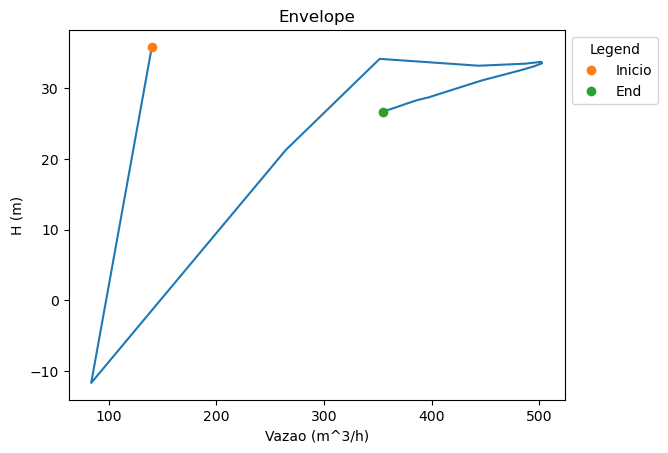

In [15]:
#BCS.Envelope.fig = @(aux) plot(q_35hz,H_35hz(q_35hz),':r',q_65hz,H_65hz(q_65hz),':r',q_ut,H_ut(q_ut),':r',q_dt,H_dt(q_dt),':r','LineWidth',2);

plt.figure(5)
plt.xlabel("Vazao (m^3/h)")
plt.ylabel("H (m)")
plt.title("Envelope")
aux20 = []
aux21 = []
aux22 = []
aux23 = []
aux24 = []
aux25 = []
for i in range(len(xs_h)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in yp],label = 'id %s'%i)
    aux20.append(xs_h[i][0])
    aux21.append(xs_h[i][1][0]) # phb
    aux22.append(xs_h[i][1][1]) # pwh
    aux23.append(xs_h[i][1][2]*3600) # q
    


plt.plot(aux14,aux23) #h 
plt.plot(aux14[0],aux23[0],'o',label='Inicio') #h 
plt.plot(aux14[-1],aux23[-1],'o',label='End') #h 

plt.legend(title='Legend', bbox_to_anchor=(1,1))
plt.show()
